In [1]:
import os
import gensim


path = os.path.join('word2vec',
        'GoogleNews-vectors-negative300.bin')
model = gensim.models.KeyedVectors.load_word2vec_format(
        path,
        binary=True
    )

In [2]:
import math
import numpy
from operator import itemgetter
from numpy.linalg import norm

EPSILON = 1e-6

def euclidean(vec1, vec2):
  diff = vec1 - vec2
  return math.sqrt(diff.dot(diff))

def cosine_sim(vec1, vec2):
  vec1 += EPSILON * numpy.ones(len(vec1))
  vec2 += EPSILON * numpy.ones(len(vec1))
  return vec1.dot(vec2)/(norm(vec1)*norm(vec2))

def assign_ranks(item_dict):
  ranked_dict = {}
  sorted_list = [(key, val) for (key, val) in sorted(item_dict.items(),
                                                     key=itemgetter(1),
                                                     reverse=True)]
  for i, (key, val) in enumerate(sorted_list):
    same_val_indices = []
    for j, (key2, val2) in enumerate(sorted_list):
      if val2 == val:
        same_val_indices.append(j+1)
    if len(same_val_indices) == 1:
      ranked_dict[key] = i+1
    else:
      ranked_dict[key] = 1.*sum(same_val_indices)/len(same_val_indices)
  return ranked_dict

def correlation(dict1, dict2):
  avg1 = 1.*sum([val for key, val in dict1.iteritems()])/len(dict1)
  avg2 = 1.*sum([val for key, val in dict2.iteritems()])/len(dict2)
  numr, den1, den2 = (0., 0., 0.)
  for val1, val2 in zip(dict1.itervalues(), dict2.itervalues()):
    numr += (val1 - avg1) * (val2 - avg2)
    den1 += (val1 - avg1) ** 2
    den2 += (val2 - avg2) ** 2
  return numr / math.sqrt(den1 * den2)

def spearmans_rho(ranked_dict1, ranked_dict2):
  assert len(ranked_dict1) == len(ranked_dict2)
  if len(ranked_dict1) == 0 or len(ranked_dict2) == 0:
    return 0.
  x_avg = 1.*sum([val for val in ranked_dict1.values()])/len(ranked_dict1)
  y_avg = 1.*sum([val for val in ranked_dict2.values()])/len(ranked_dict2)
  num, d_x, d_y = (0., 0., 0.)
  for key in ranked_dict1.keys():
    xi = ranked_dict1[key]
    yi = ranked_dict2[key]
    num += (xi-x_avg)*(yi-y_avg)
    d_x += (xi-x_avg)**2
    d_y += (yi-y_avg)**2
  return num/(math.sqrt(d_x*d_y))

In [3]:
vec1=model['test'].tolist()
vec2 =model['exam'].tolist()
cosine_sim(vec1,vec2)

0.5065850456386709

In [51]:
data = model.vectors
print(data.shape)

(3000000, 300)


In [61]:
import numpy as np
num_points = 100000
selected_index = np.random.choice(data.shape[0],size=num_points, replace=True)
train_data = data[selected_index,:]
words = np.array(model.index2word)[selected_index]

In [58]:
def run_word_sim(model,u):
    print ('======================================================================================')
    print ("%15s" % "Num Pairs", "%10s" % "Not found", "%15s" % "Word2Vec Rho",  "%15s" % "UMAPed Rho", "word2vec/umap","File name")
    print ('======================================================================================')

    word_sim_file="data/word-sim/EN-RW-STANFORD.txt"
    word_sim_dir="data/word-sim"

    for i, filename in enumerate(os.listdir(word_sim_dir)):
        not_found, total_size = (0, 0)
        manual_dict, auto_dict,reduced_dict = ({}, {},{})

        for line in open(word_sim_dir+"/"+filename,'r'):
            line = line.strip().lower()
            word1, word2, val = line.split()
            try:
                vec1= model[word1].tolist()
                vec2 = model[word2].tolist()

                u_vec1 = u.transform([vec1] )[0]
                u_vec2 =  u.transform([vec2] )[0]

            except Exception as e:
                not_found+=1
                next 
            manual_dict[(word1, word2)] = float(val)
            auto_dict[(word1, word2)] = cosine_sim(vec1, vec2)
            reduced_dict[(word1, word2)] = cosine_sim(u_vec1, u_vec2)
            total_size += 1    
        print ( "%15s" % str(total_size), "%10s" % str(not_found), "%15.4f" % spearmans_rho(assign_ranks(manual_dict), assign_ranks(auto_dict)),
               "%15.4f" % spearmans_rho(assign_ranks(manual_dict), assign_ranks(reduced_dict)),"%15.4f" % spearmans_rho(assign_ranks(auto_dict), assign_ranks(reduced_dict)),
              filename)


In [62]:
import umap

fit10 = umap.UMAP(n_neighbors=15, random_state=42,n_components=10, metric='cosine')
%time u10 = fit10.fit(train_data)
run_word_sim (model,u10)

fit30 = umap.UMAP(n_neighbors=15, random_state=42,n_components=30, metric='cosine')
%time u30 = fit30.fit(train_data)
run_word_sim (model,u30)
fit50 = umap.UMAP(n_neighbors=15, random_state=42,n_components=50, metric='cosine')
%time u50 = fit50.fit(train_data)
run_word_sim (model,u50)

fit100 = umap.UMAP(n_neighbors=15, random_state=42,n_components=100, metric='cosine')
%time u100 = fit100.fit(train_data)
run_word_sim (model,u100)

fit150 = umap.UMAP(n_neighbors=15, random_state=42,n_components=150, metric='cosine')
%time u150 = fit150.fit(train_data)
run_word_sim (model,u150)









/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


CPU times: user 3min 59s, sys: 3.65 s, total: 4min 3s
Wall time: 3min 20s
      Num Pairs  Not found    Word2Vec Rho      UMAPed Rho word2vec/umap File name


/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", li

            130          0          0.5590          0.0273          0.3919 EN-YP-130.txt
             65          0          0.7498          0.4048          0.3524 EN-RG-65.txt
            287         12          0.6453          0.3961          0.5054 EN-MTurk-287.txt
            999          0          0.4420          0.1079          0.4911 EN-SIMLEX-999.txt
            144          9          0.4929          0.1350          0.4024 EN-VERB-143.txt
            252          2          0.6241          0.3610          0.3465 EN-WS-353-REL.txt
           2034        209          0.4747          0.1743          0.4596 EN-RW-STANFORD.txt
           3000         54          0.7610          0.4584          0.6496 EN-MEN-TR-3k.txt
            353          3          0.6858          0.4024          0.5018 EN-WS-353-ALL.txt
             30          0          0.7880          0.2688          0.1373 EN-MC-30.txt
            771          0          0.6713          0.2039          0.4053 EN-MTurk-771

/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


CPU times: user 8min 21s, sys: 7.76 s, total: 8min 29s
Wall time: 7min 1s
      Num Pairs  Not found    Word2Vec Rho      UMAPed Rho word2vec/umap File name


/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", li

            130          0          0.5590          0.0291          0.3926 EN-YP-130.txt
             65          0          0.7498          0.4205          0.3559 EN-RG-65.txt
            287         12          0.6453          0.3942          0.5070 EN-MTurk-287.txt
            999          0          0.4420          0.1083          0.4918 EN-SIMLEX-999.txt
            144          9          0.4929          0.1417          0.4088 EN-VERB-143.txt
            252          2          0.6241          0.3520          0.3484 EN-WS-353-REL.txt
           2034        209          0.4747          0.1760          0.4600 EN-RW-STANFORD.txt
           3000         54          0.7610          0.4591          0.6494 EN-MEN-TR-3k.txt
            353          3          0.6858          0.4079          0.5139 EN-WS-353-ALL.txt
             30          0          0.7880          0.2806          0.1355 EN-MC-30.txt
            771          0          0.6713          0.2093          0.4077 EN-MTurk-771

/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


CPU times: user 12min 27s, sys: 10.8 s, total: 12min 37s
Wall time: 10min 25s
      Num Pairs  Not found    Word2Vec Rho      UMAPed Rho word2vec/umap File name


/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", li

            130          0          0.5590          0.0329          0.3962 EN-YP-130.txt
             65          0          0.7498          0.4118          0.3546 EN-RG-65.txt
            287         12          0.6453          0.3937          0.5067 EN-MTurk-287.txt
            999          0          0.4420          0.1072          0.4917 EN-SIMLEX-999.txt
            144          9          0.4929          0.1433          0.4001 EN-VERB-143.txt
            252          2          0.6241          0.3502          0.3472 EN-WS-353-REL.txt
           2034        209          0.4747          0.1753          0.4660 EN-RW-STANFORD.txt
           3000         54          0.7610          0.4591          0.6497 EN-MEN-TR-3k.txt
            353          3          0.6858          0.4074          0.5133 EN-WS-353-ALL.txt
             30          0          0.7880          0.2824          0.1364 EN-MC-30.txt
            771          0          0.6713          0.2063          0.4078 EN-MTurk-771

/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


CPU times: user 21min 13s, sys: 17 s, total: 21min 30s
Wall time: 17min 37s
      Num Pairs  Not found    Word2Vec Rho      UMAPed Rho word2vec/umap File name


/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", li

            130          0          0.5590          0.0308          0.3969 EN-YP-130.txt
             65          0          0.7498          0.4162          0.3549 EN-RG-65.txt
            287         12          0.6453          0.3896          0.5064 EN-MTurk-287.txt
            999          0          0.4420          0.1076          0.4941 EN-SIMLEX-999.txt
            144          9          0.4929          0.1434          0.4050 EN-VERB-143.txt
            252          2          0.6241          0.3533          0.3483 EN-WS-353-REL.txt
           2034        209          0.4747          0.1710          0.4605 EN-RW-STANFORD.txt
           3000         54          0.7610          0.4588          0.6498 EN-MEN-TR-3k.txt
            353          3          0.6858          0.4025          0.5053 EN-WS-353-ALL.txt
             30          0          0.7880          0.2806          0.1355 EN-MC-30.txt
            771          0          0.6713          0.2058          0.4078 EN-MTurk-771

/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


CPU times: user 31min 8s, sys: 17.3 s, total: 31min 25s
Wall time: 25min 31s
      Num Pairs  Not found    Word2Vec Rho      UMAPed Rho word2vec/umap File name


/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", line 124:
    @numba.njit(parallel=True)
    def init_from_random(n_neighbors, data, query_points, heap, rng_state):
    ^

  state.func_ir.loc))
/home/wes/UMAP_experiments/.venv/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File ".venv/lib/python3.6/site-packages/umap/nndescent.py", li

            130          0          0.5590          0.0329          0.3967 EN-YP-130.txt
             65          0          0.7498          0.4122          0.3536 EN-RG-65.txt
            287         12          0.6453          0.3935          0.5068 EN-MTurk-287.txt
            999          0          0.4420          0.1068          0.4920 EN-SIMLEX-999.txt
            144          9          0.4929          0.1577          0.3885 EN-VERB-143.txt
            252          2          0.6241          0.3507          0.3486 EN-WS-353-REL.txt
           2034        209          0.4747          0.1713          0.4580 EN-RW-STANFORD.txt
           3000         54          0.7610          0.4575          0.6481 EN-MEN-TR-3k.txt
            353          3          0.6858          0.4074          0.5132 EN-WS-353-ALL.txt
             30          0          0.7880          0.2820          0.1390 EN-MC-30.txt
            771          0          0.6713          0.2063          0.4055 EN-MTurk-771

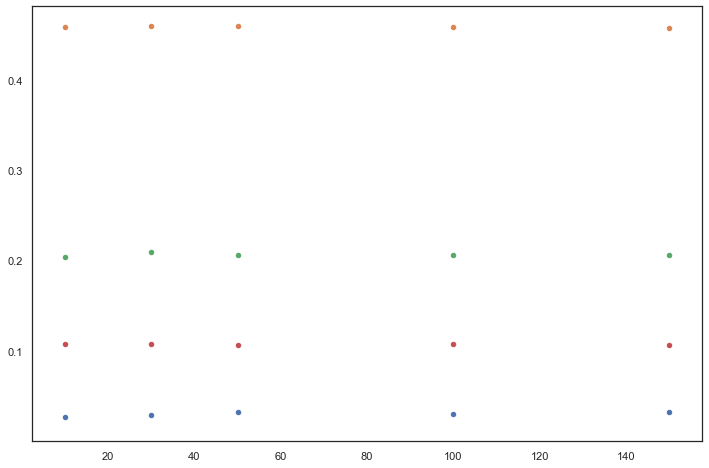

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='white', rc={'figure.figsize':(12,8)})

x=[10,30,50,100,150]

y=[ 0.0273,0.0291, 0.0329,0.0308,0.0329 ] #EN-YP-130.txt

y2=[0.4584, 0.4591,0.4591 ,0.4588,0.4575] #EN-MEN-TR-3k.txt


y3=[0.2039,0.2093 ,0.2063 ,0.2058,0.2063] #EN-MTurk-771.txt

y4=[0.1079 ,0.1083 ,0.1072, 0.1076 ,0.1068 ] #EN-SIMLEX-999.txt

plt.scatter(x,y,s=20)
plt.scatter(x,y2,s=20)
plt.scatter(x,y3,s=20)
plt.scatter(x,y4,s=20)